# CNN에 대하여
로보인 Zoom 세미나 2021.11.23

담당 : 장민준

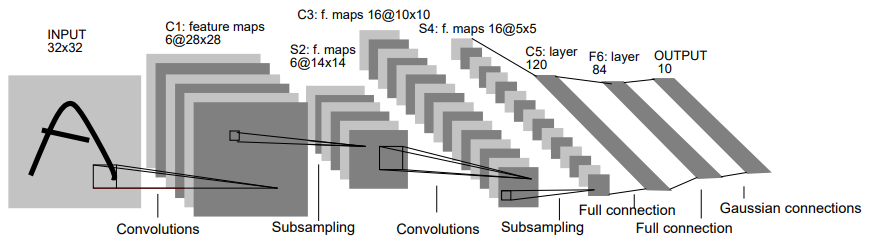

- convolution layer에서는 cross-corelation 연산
- padding, stride 설정
- pooling layer에서는 보통 max-pooling

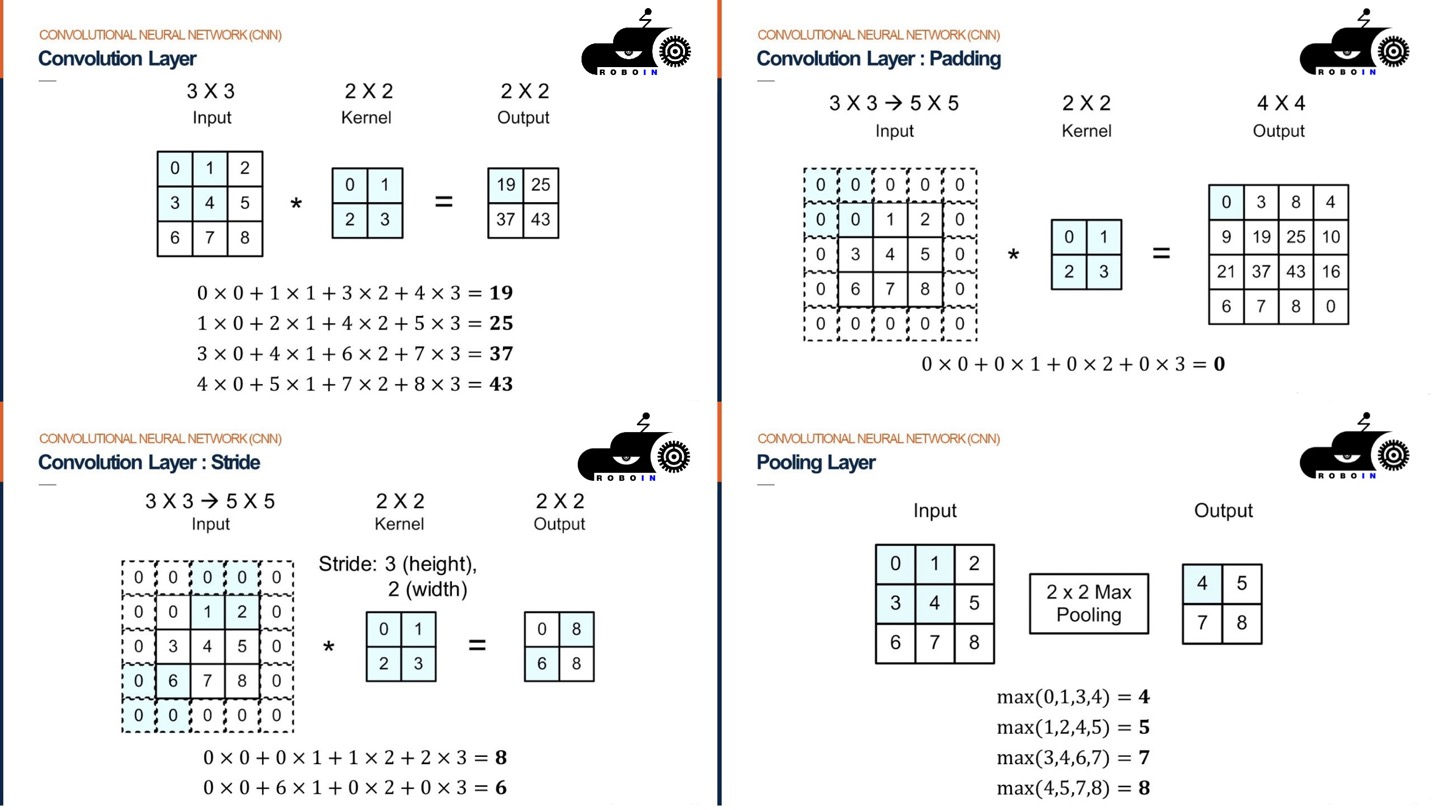

# MNIST Dataset 사용하여 학습시키기

**시작 전 [런타임] > [런타임 유형 변경] > [하드웨어 가속기] > [GPU] 선택**

<a title="By Josef Steppan [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)], from Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:MnistExamples.png"><img width="512" alt="MnistExamples" src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"/></a>
[MNIST Examples]

In [1]:
# Import required libraries

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
from torchvision import datasets, transforms
from torch.autograd import Variable


In [2]:
# Variables

args = {}
kwargs = {}
args['batch_size'] = 1000 # Batch size
args['test_batch_size'] = 1000 # Test batch size
args['epochs'] = 10  # The number of epochs is the number of times you go through the full dataset.
args['lr'] = 0.01 # Learning rate is how fast it will decend.

args['seed'] = 1 # random seed
args['log_interval'] = 10 # log interval
args['cuda'] = True # GPU cuda enable


In [3]:
# Load the MNIST data
# Train loader
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.,), (1.,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)

# Test loader
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.,), (1.,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw





**LeNet5 모델**



\

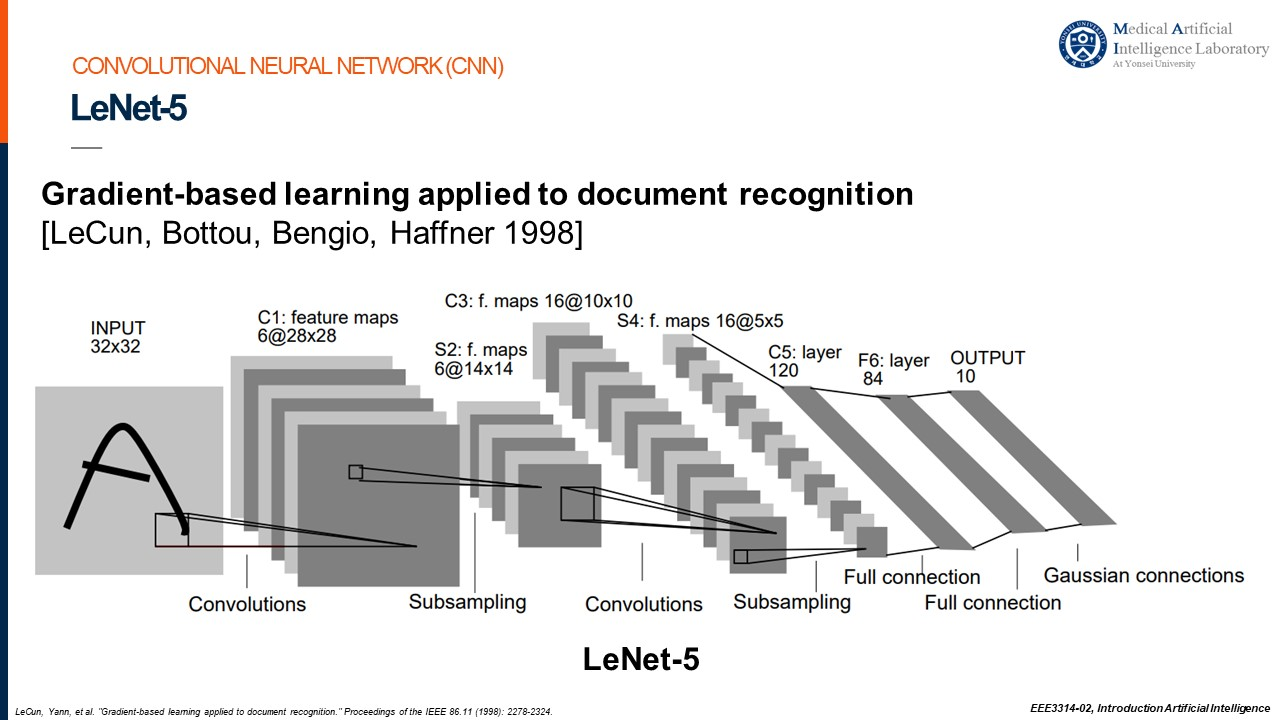


In [4]:
### Implement your code ###

class LeNet(nn.Module):
    # Define the structure of the LeNet

    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1,6,kernel_size=5) # convolution layer 1, 5*5 kernel
        self.conv2 = nn.Conv2d(6,16,kernel_size=5) # convolution layer 2, 5*5 kernel
        self.conv3 = nn.Conv2d(16,120,kernel_size=5) # convolution layer 3, 5*5 kernel
        self.fc1 = nn.Linear(120,84)# full connection
        self.fc2 = nn.Linear(84,10)# full connection

    def forward(self, x):
        x = torch.tanh(self.conv1(x)) #convolution1 --> activation
        x = F.avg_pool2d(x,2,2) #max pooling1
        x = torch.tanh(self.conv2(x)) #convolution2 --> activation
        x = F.avg_pool2d(x,2,2) #max pooling2
        x = torch.tanh(self.conv3(x)) #convolution3 --> activation
        x = x.view(-1,120)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1) # log softmax 연산


In [5]:
# Classes
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


In [6]:
# Definition of train

def train(epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        # Cuda variable
        if args['cuda']:
            data, target = data.cuda(), target.cuda()

        # Pytorch variables
        data, target = Variable(data), Variable(target)

        # zero_grad() will zero out the gradients for this batch.
        optimizer.zero_grad()

        # The defined model generates the output.
        output = model(data)

        # Calculate the loss (negative log likelihood loss).
        loss = F.nll_loss(output, target)

        # Loss backpropagation
        loss.backward()

        # To do a one-step update on our parameter.
        optimizer.step()

        # Print out the logs periodically
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))


In [7]:
# Definition of test

def test(print_class_accuracy):
    model.eval()

    # Initilize the variables
    test_loss = 0
    correct = 0
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # torch.no_grad() for test
    with torch.no_grad():
      for data, target in test_loader:
          # Cuda variable
          if args['cuda']:
              data, target = data.cuda(), target.cuda()

          # The trained model generates the output.
          output = model(data)

          # Calculates the test loss
          test_loss += F.nll_loss(output, target, reduction='sum').data # sum up batch loss

          # Get the index of the max log-probability
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

          # Calculate the accuracy for each class
          for label, prediction in zip(target, pred):
            if label == prediction:
              correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

      test_loss /= len(test_loader.dataset)

      # Print out the logs periodically
      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      
      # Print out the accuracy for each class
      if print_class_accuracy == True:
        for classname, correct_count in correct_pred.items():
          accuracy = 100 * float(correct_count) / total_pred[classname]
          print("Accuracy for class {:s}: {:d}/{:d} ({:.1f}%)".format(classname,correct_count,total_pred[classname],accuracy))


In [9]:
model = LeNet()

In [10]:
# GPU usage
if args['cuda']:
    model.cuda()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01) # learning rate 0.001-->0.1변경

# Train & Test for defined epochs
for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test(print_class_accuracy=False)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307791
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.525481
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.324896
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.232121
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.240877
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.204867

Test set: Average loss: 0.1487, Accuracy: 9543/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.158217
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.137424
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.130343
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.110712
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.122604
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.117318

Test set: Average loss: 0.1022, Accuracy: 9696/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.099091
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.075831
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.059787
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.092190
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.065801
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.

In [11]:
# Accuracy for each class

test(print_class_accuracy = True)


Test set: Average loss: 0.0559, Accuracy: 9827/10000 (98%)

Accuracy for class 0: 973/980 (99.3%)
Accuracy for class 1: 1121/1135 (98.8%)
Accuracy for class 2: 1009/1032 (97.8%)
Accuracy for class 3: 997/1010 (98.7%)
Accuracy for class 4: 962/982 (98.0%)
Accuracy for class 5: 873/892 (97.9%)
Accuracy for class 6: 936/958 (97.7%)
Accuracy for class 7: 1006/1028 (97.9%)
Accuracy for class 8: 955/974 (98.0%)
Accuracy for class 9: 995/1009 (98.6%)


In [12]:
# Test data shape
for data, target in test_loader:
  print(data.shape)
target[0:40]

torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])


tensor([0, 9, 9, 3, 6, 3, 5, 9, 5, 5, 8, 7, 3, 5, 3, 6, 4, 8, 6, 7, 1, 5, 9, 4,
        8, 0, 9, 2, 9, 9, 7, 7, 4, 1, 3, 0, 1, 8, 5, 0])

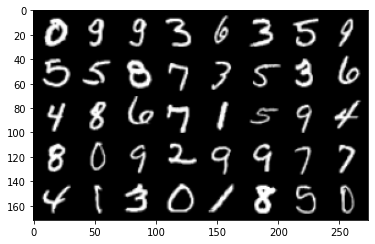

In [13]:
# imshow function

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(data[0:40]))

In [14]:
output = model(data.cuda())
pred = output.data.max(1, keepdim=True)[1]

In [15]:
torch.reshape(pred.cpu()[0:40],(5,8))

tensor([[0, 9, 9, 3, 6, 3, 5, 9],
        [5, 5, 8, 7, 3, 5, 3, 6],
        [4, 8, 6, 7, 1, 5, 9, 4],
        [8, 0, 9, 2, 9, 9, 7, 7],
        [4, 1, 3, 0, 1, 8, 5, 0]])

#손으로 쓴 handwritten dataset 예측해보기


In [20]:
# Google Drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# 직접 만든 손글씨 전처리
# 흰 바탕에 검은 글씨 색반전시켜 학습한 것과 같이 검은 배경에 흰 글씨로 변경
for i in range(10):
  for j in range(1, 11):
    data_path = '/content/drive/MyDrive/RoboInSeminar/bf_preprocess/'+str(i)+'-'+str(j)+'.jpg' #bf_preprocess 폴더에서 원본 이미지 불러오기
    org = cv.imread(data_path) # org에 원본 이미지 저장
    out = org.copy() # 이미비 out에 복사
    out = 255 - out # 색 반전
    #저장
    cv.imwrite('/content/drive/MyDrive/RoboInSeminar/testset/'+str(i)+'/'+str(i)+'-'+str(j)+'.jpg',out) # 데이터셋 저장

torch.Size([100, 1, 32, 32])
정답
tensor([[8, 1, 2, 1, 0, 8, 2, 3, 7, 3],
        [5, 7, 2, 1, 5, 9, 6, 6, 0, 4],
        [4, 5, 6, 4, 9, 3, 6, 8, 8, 9],
        [7, 6, 3, 6, 0, 5, 2, 5, 4, 8],
        [3, 4, 0, 1, 8, 9, 3, 7, 6, 5],
        [2, 4, 4, 9, 7, 0, 9, 6, 7, 4],
        [9, 1, 1, 7, 9, 0, 1, 0, 8, 9],
        [8, 2, 9, 1, 7, 0, 4, 1, 7, 1],
        [5, 7, 3, 0, 4, 5, 2, 3, 8, 3],
        [8, 3, 2, 0, 5, 6, 5, 2, 2, 6]])



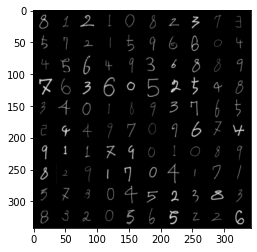

In [22]:
### 1) Load and plot your written digits here ###
data_path = '/content/drive/MyDrive/RoboInSeminar/testset'
data_transforms = transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor(),
                       transforms.Normalize((0,), (1.,)),
                       transforms.Grayscale(num_output_channels=1) # 3channel 이미지이므로 1channel data로 변경
                   ])
handwritten_datasets = datasets.ImageFolder(root = data_path, transform=data_transforms)
handTest_loader = torch.utils.data.DataLoader(dataset = handwritten_datasets, batch_size=args['test_batch_size'], shuffle=True, **kwargs)

for customdata, target in handTest_loader:
  print(customdata.shape) 

ans = torch.reshape(target[0:100],(10,10))
print("정답") # CNN 모델이 맞추고자 하는 정답 데이터
print(ans)
print()
imshow(torchvision.utils.make_grid(customdata[0:100],10))

In [23]:
### 2) Print test accuracy with your written digits here ###
customoutput = model(customdata.cuda())
custompred = customoutput.data.max(1, keepdim=True)[1]
custompred = torch.reshape(custompred.cpu()[0:100],(10,10))
print("신경망이 예측한 숫자")
print(custompred) # prediction 값

# 일치율을 %를 나타내기 위한 코드
cnt = 0
err = ans - custompred
err = err.numpy()
size = err.size
[R, C] = err.shape

# 정답과 같을 때마다 cnt + 1
for i in range(R):
  for j in range(C):
    if err[i,j]==0:
      cnt+=1
      
# % 단위로 변환 
crt_rate = int((cnt/size)*100)

print("accuracy : ",crt_rate,"%")



신경망이 예측한 숫자
tensor([[8, 1, 2, 1, 9, 8, 2, 9, 7, 3],
        [5, 7, 3, 1, 3, 9, 5, 8, 7, 4],
        [4, 5, 5, 4, 9, 3, 5, 8, 3, 9],
        [2, 6, 3, 5, 9, 5, 2, 5, 9, 3],
        [9, 4, 0, 1, 3, 9, 3, 1, 5, 5],
        [5, 4, 4, 7, 7, 9, 9, 5, 8, 4],
        [9, 1, 1, 3, 9, 5, 1, 9, 9, 9],
        [8, 3, 7, 5, 8, 9, 9, 5, 3, 1],
        [9, 8, 9, 2, 5, 5, 1, 7, 3, 3],
        [8, 9, 2, 7, 5, 5, 5, 2, 2, 0]])
accuracy :  52 %


CNN 모델로 예측한 커스텀 손글씨 Accuracy : 52%